# WRF Forecast to Power Tutorial

This tutorial will walk through the process of going from a WRF forecast model data to AC power using the SAPM.

Table of contents:
1. [Setup](#Setup)
2. [Load Forecast Data](#Load-Forecast-Data)
2. [Pull a location from NY-Sun Database and extract meteorological data](#Pull-a-location-from-NY-Sun-Database-and-extract-meteorological-data)
2. [Module-Specific Power Calculation](#Module-Specific-Power-Calculationn)
2. [Nameplate Capacity-Based Power Calculation](#Nameplate-Capacity-Based-Power-Calculation)

This tutorial requires pvlib from [my GitHub repo](https://github.com/jeffreysward/pvlib-python)!

Authors:
* Jeffrey Sward (jas983@cornell.edu), Cornell University, November 2020

## Setup

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
from optwrf import runwrf as rw
from optwrf import postwrf as pw
from optwrf import util

# Import the pvlib module
import pvlib
from pvlib.wrfcast import WRF
from pvlib.location import Location
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.modelchain import ModelChain

## Load Forecast Data

In [2]:
# Specify the forecast model as WRF
fm = WRF()

In [7]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# absolute path to WRF data file
DIR_WRFOUT = os.path.join(pvlib_abspath, 'data/')
wrfout_file = 'wrfout_d01_2011-01-24_01:00:00'

# Get/process the data from the wrfout file
forecast_data = pw.process_wrfout_manual(DIR_WRFOUT, wrfout_file, save_file=False)

The ``xarray Dataset`` below shows which variables are included in the processed WRF data

In [8]:
forecast_data.head()

<xarray.Dataset>
Dimensions:         (Time: 5, bottom_top: 5, south_north: 5, west_east: 5)
Coordinates:
    XLONG           (south_north, west_east) float32 -95.43335 ... -94.920715
    XLAT            (south_north, west_east) float32 30.952759 ... 31.37416
  * Time            (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-24T...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    temp_air        (Time, south_north, west_east) float32 14.474274 ... 11.2...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 0.0 .....
    cos_zenith      (Time, south_north, west_east) float32 -0.23945779 ... -0...
    dni             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    dhi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    height_agl      (Time, bottom_top, south_north, west_east) float32 10.115...
    wspd            (Time, bottom_top, south_north, west_east) float32 1.0828...
    wdir            (Time, bottom_top, south_north, west_east) float32 195.71...
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed100   (Time, south_north, west_east) float32 2.304195 ... 4.213...
    wpd             (Time, south_north, west_east) float32 6116.8477 ... 3739...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                      2011-01-24_00:00:00
    SIMULATION_START_DATE:           2011-01-23_12:00:00
    WEST-EAST_GRID_DIMENSION:        192
    SOUTH-NORTH_GRID_DIMENSION:      192
    BOTTOM-TOP_GRID_DIMENSION:       36
    DX:                              12000.0
    DY:                              12000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        0
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      10
    RA_LW_PHYSICS:                   1
    RA_SW_PHYSICS:                   1
    SF_SFCLAY_PHYSICS:               2
    SF_SURFACE_PHYSICS:              2
    BL_PBL_PHYSICS:                  5
    CU_PHYSICS:                      3
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      0
    GRID_FDDA:                       1
    GFDDA_INTERVAL_M:                180
    GFDDA_END_H:                     132
    GRID_SFDDA:                      1
    SGFDDA_INTERVAL_M:               360
    SGFDDA_END_H:                    120
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     0
    SF_URBAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        1
    SMOOTH_OPTION:                   0
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       0
    DT:                              45.0
    RADT:                            15.0
    BLDT:                            0.0
    CUDT:                            0.0
    AER_OPT:                         0
    SWINT_OPT:                       1
    AER_TYPE:                        1
    AER_AOD550_OPT:                  1
    AER_ANGEXP_OPT:                  1
    AER_SSA_OPT:                     1
    AER_ASY_OPT:                     1
    AER_AOD550_VAL:                  0.12
    AER_ANGEXP_VAL:                  1.3
    AER_SSA_VAL:                     1e-45
    AER_ASY_VAL:                     1e-45
    MOIST_ADV_OPT:                   1
    SCALAR_ADV_OPT:                  1
    TKE_ADV_OPT:                     1
    DIFF_6TH_OPT:                    0
    DIFF_6TH_FACTOR:                 0.12
    FGDT:                            0.0
    GUV:                             0.0003
    GT:       

In [46]:
#  Interpolate wind speeds to 10m height
forecast_data['wind_speed'] = wrf.interplevel(forecast_data['wspd'], forecast_data['height_agl'], 10)

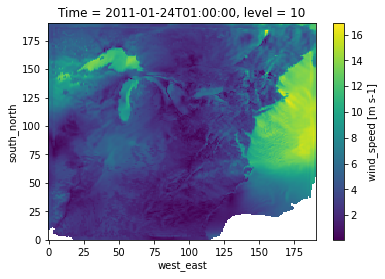

In [47]:
forecast_data.wind_speed.isel(Time=0).plot()

## Pull a location from NY-Sun Database and extract meteorological data

In [25]:
# Get location data from NY-Sun Database
location = Location(latitude=40.7484, longitude=-73.9967)
location

Location: 
  name: None
  latitude: 40.7484
  longitude: -73.9967
  altitude: 0
  tz: UTC

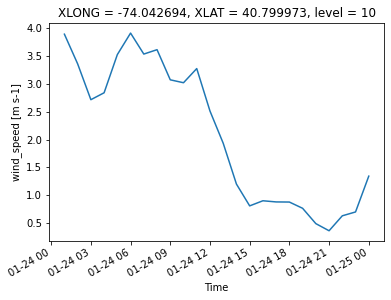

In [48]:
# Extract data for this location from the processed WRF data
# Here is a way of doing it that works well for multiple points 
# (i.e., you create a Kdtree_ll_to_xy class and query it when you need a pair of indicies)
ns = util.Kdtree_ll_to_xy(forecast_data,'XLAT','XLONG')
iy,ix = ns.query(location.latitude, location.longitude)
forecast_data.wind_speed.isel(west_east=ix, south_north=iy).plot()

In [54]:
location_forecast = forecast_data.isel(west_east=ix, south_north=iy)

In [55]:
location_forecast = location_forecast[['dni', 'dhi', 'ghi', 'temp_air', 'wind_speed']].to_dataframe()

## Module-Specific Power Calculation

In [15]:
# Specify a module/inverter pair for the PVSystem
sandia_modules = retrieve_sam('SandiaMod')
sapm_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

In [22]:
# Specify the PVSystem (i.e., what the system looks like that we are calculating the power for)
# Perhaps we can pull this information from the NY-Sun Database at some point as well, 
# but it would certainly take a long time to process each time, 
# so I would probably need to save it to a local database.
system = PVSystem(module_parameters=module,
                  inverter_parameters=inverter,
                  orientation_strategy='south_at_latitude_tilt')

In [23]:
# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, location)

In [56]:
# extract relevant data for model chain
mc.run_model(location_forecast)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

<AxesSubplot:xlabel='Time'>

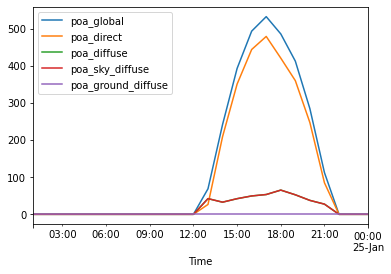

In [57]:
# This plot shows the irradiance (I assume the y-axis units are W/m^2, but I'm not sure).
mc.total_irrad.plot()

<AxesSubplot:xlabel='Time'>

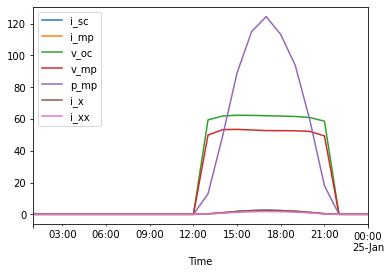

In [60]:
# This plot shows the results of the DC model (I assume the y-axis units are W, but I'm not sure).
mc.dc.plot()

<AxesSubplot:xlabel='Time'>

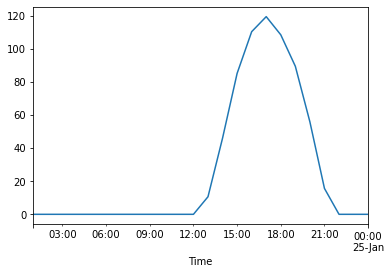

In [59]:
# This plot shows the AC power output (I assume the y-axis units are W, but I'm not sure).
# I reason this based on the fact the the module is rated to 220W, and the example here is for Jan 25.
mc.ac.plot()

## Nameplate Capacity-Based Power Calculation

<AxesSubplot:xlabel='Time'>

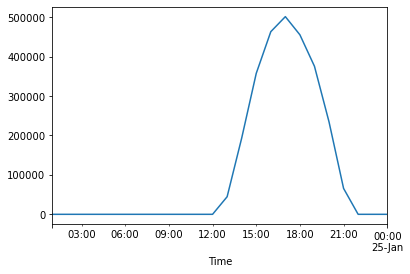

In [68]:
# We now scale the above profile based upon the total nameplate capacity
totalnameplatewdc = 923.9800 * 1000  # convert from kWdc to Wdc
ac_power = mc.ac/220 * totalnameplatewdc
ac_power.plot() # Note that this plot is in Watts